# 🔍 Zero-Shot Image Classification mit CLIP
Dieses Notebook verwendet ein Zero-Shot-Modell (CLIP), um Bilder aus dem Utility-Poles-Datensatz zu klassifizieren.

## Imports

In [1]:
import os
from glob import glob
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pfade & Labels

In [2]:
image_paths = glob('utility_poles_renamed/*.jpg')
labels = sorted(set(os.path.basename(p).split('_')[0] for p in image_paths))
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
print(f"{len(labels)} Labels erkannt")

96 Labels erkannt


## Modell & Prozessor

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arija\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Zero-Shot Prediction

In [4]:
y_true, y_pred = [], []

for path in image_paths:
    true_label = os.path.basename(path).split('_')[0]
    image = Image.open(path).convert("RGB")
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    pred_id = torch.argmax(logits_per_image, dim=1).item()
    y_pred.append(labels[pred_id])
    y_true.append(true_label)

## Auswertung

In [8]:
report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
print(report)

               precision    recall  f1-score   support

      Albania       1.00      0.17      0.29         6
    Argentina       0.00      0.00      0.00         7
    Australia       0.57      0.40      0.47        10
      Austria       0.00      0.00      0.00        11
   Bangladesh       1.00      0.25      0.40         4
      Belgium       0.00      0.00      0.00         4
       Bhutan       0.33      0.33      0.33         3
      Bolivia       0.00      0.00      0.00         4
       Bosnia       0.00      0.00      0.00         1
     Botswana       0.33      0.50      0.40         2
       Brazil       0.00      0.00      0.00         5
     Bulgaria       0.33      0.67      0.44         3
     Cambodia       0.00      0.00      0.00         4
       Canada       0.67      0.12      0.21        16
        Chile       0.07      0.25      0.11         4
        China       0.00      0.00      0.00         1
    Christmas       0.00      0.00      0.00         1
     Colo

## Confusion Matrix

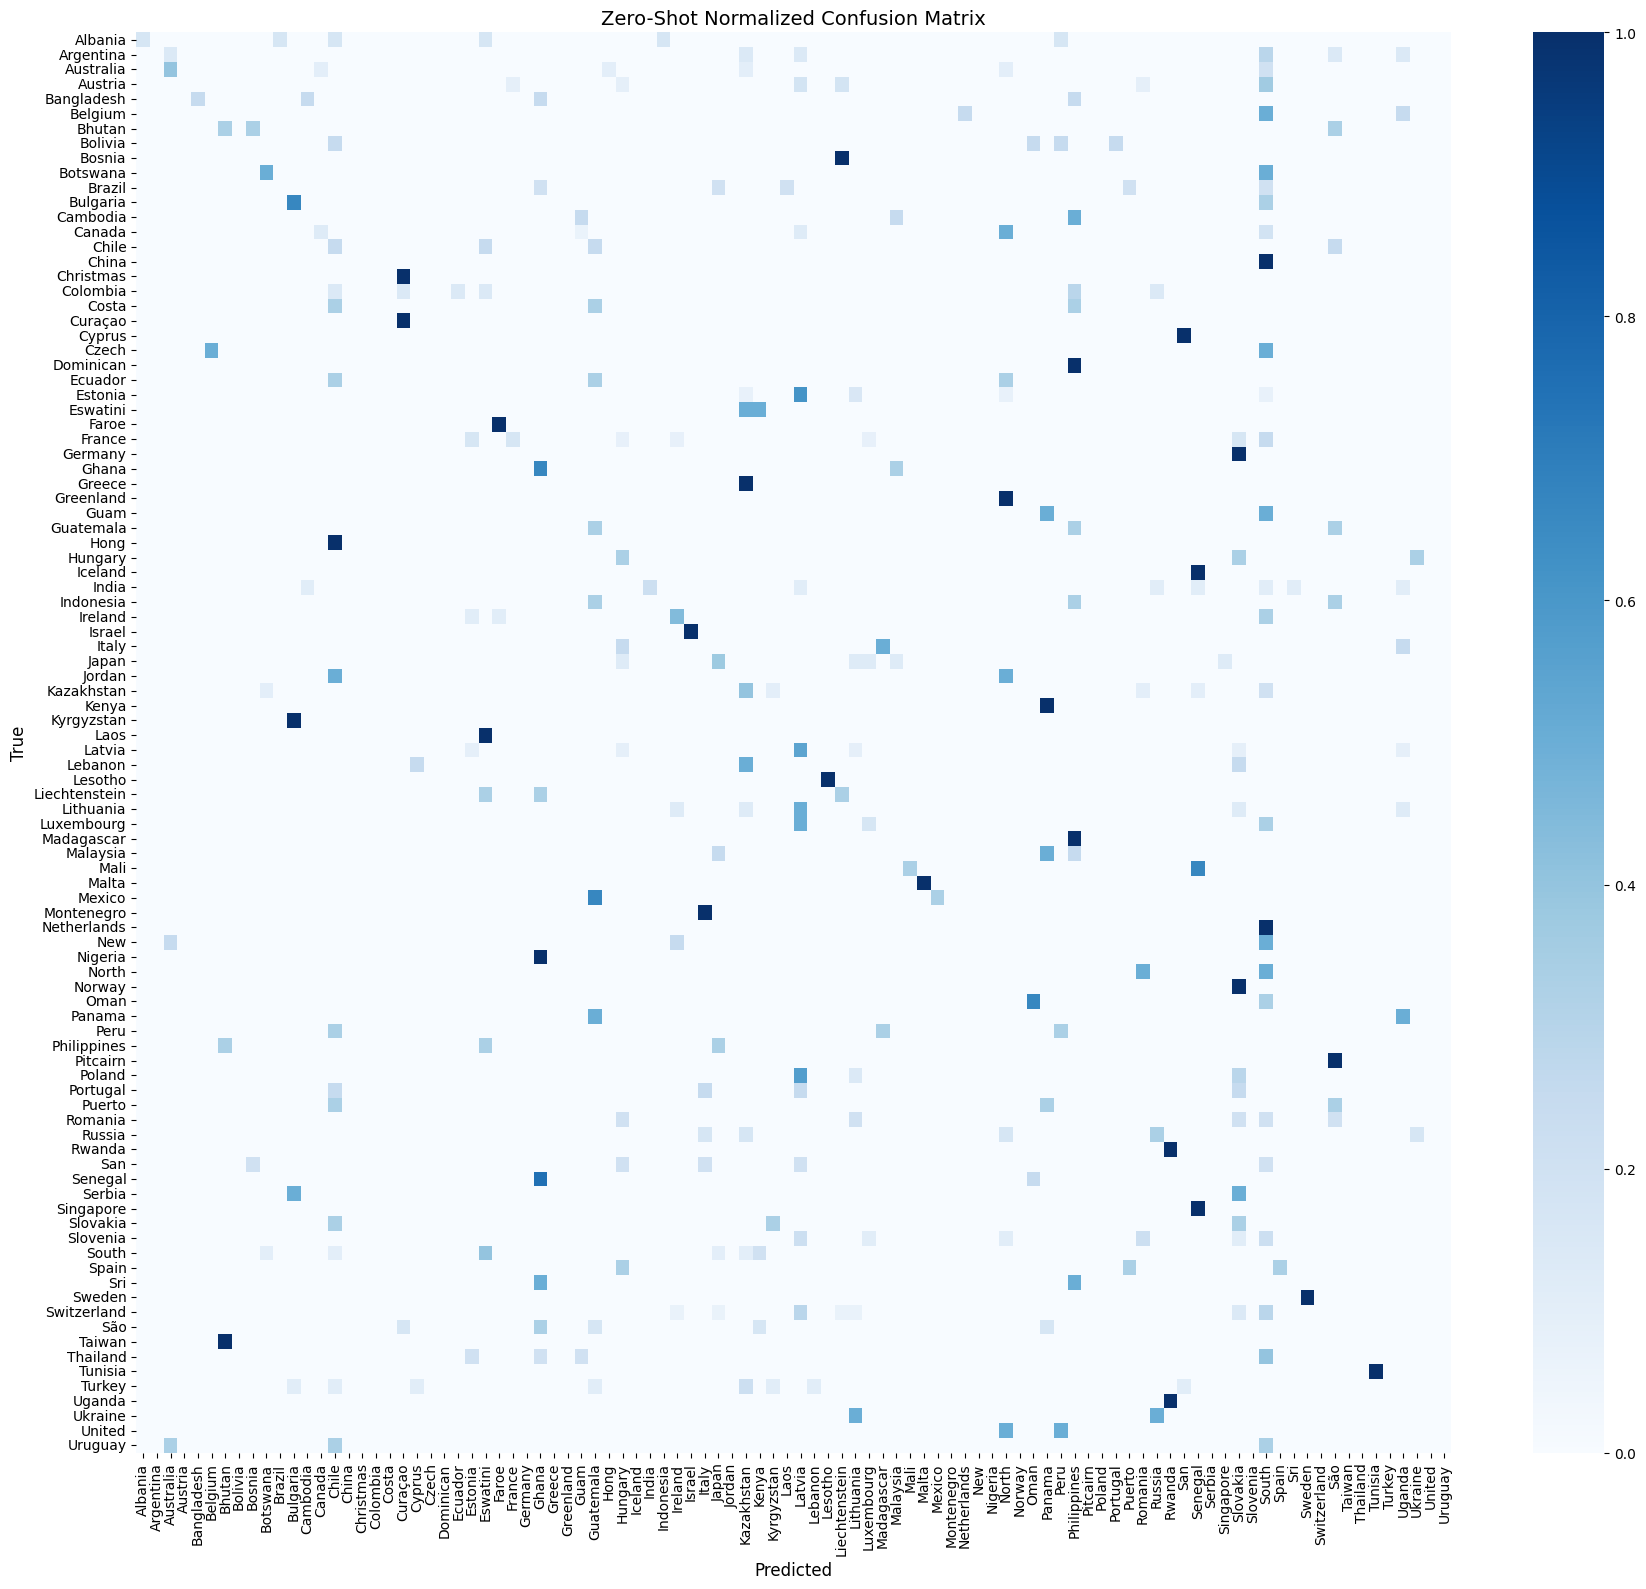

In [6]:
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(cm, annot=False, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=True, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Zero-Shot Normalized Confusion Matrix', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
os.makedirs("doc", exist_ok=True)
plt.tight_layout()
plt.savefig("doc/zero_shot_confusion_matrix.png")
plt.show()